In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
from helpers.replay_buffer import ReplayBuffer
from tabular_environments.chain_environment import SimpleChain
from helpers.shedules import LinearSchedule
from helpers.create_empty_directory import create_empty_directory
from helpers.plots import plot_q_func_and_visitations

In [32]:
from qlearning.train import train_tabular
from qlearning.models import Qnet

In [33]:
dim_range = np.arange(5, 65, 5).astype('int32')
seed_range =[10, 42, 51]
eps_params = {'exploration_fraction': 0.25,
              'exploration_final_eps': 0.001}


In [34]:
dim_range

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], dtype=int32)

In [35]:
common_params = dict( gamma=0.99, write_logs=None, do_pretraining=True,
                     plot_freq=None, print_freq=None, target_type='double_q_learning')

experiments = []

experiments.append({'name': 'eps_greedy',
                    'params': dict(eps_params=eps_params, act_type='epsilon_greedy', reward_shaping_type=None),
                    'iterate_seeds': True})
# ----------------------------------------------------------------------------- #
experiments.append({'name': 'ucb-1',
                    'params': dict(eps_params=None, act_type='ucb-1', reward_shaping_type=None),
                    'iterate_seeds': True})

# ----------------------------------------------------------------------------- #
experiments.append({'name': 'count_based_state_action',
                    'params': dict(eps_params=None, act_type='epsilon_greedy',
                                   reward_shaping_type='count_based_state_action'),
                    'iterate_seeds': True})

experiments.append({'name': 'count_based_next_state_action',
                    'params': dict(eps_params=None, act_type='epsilon_greedy',
                                   reward_shaping_type='count_based_next_state_action'),
                    'iterate_seeds': True})

experiments.append({'name': 'count_based_state',
                    'params': dict(eps_params=None, act_type='epsilon_greedy',
                                       reward_shaping_type='count_based_state'),
                    'iterate_seeds': True})

experiments.append({'name': 'count_based_next_state',
                    'params': dict(eps_params=None, act_type='epsilon_greedy',
                                   reward_shaping_type='count_based_next_state'),
                    'iterate_seeds': True})
# ----------------------------------------------------------------------------- #
experiments.append({'name': 'eps_greedy_count_based_state_action',
                    'params': dict(eps_params=eps_params, act_type='epsilon_greedy',
                                   reward_shaping_type='count_based_state_action'),
                    'iterate_seeds': True})

experiments.append({'name': 'eps_greedy_count_based_next_state_action',
                    'params': dict(eps_params=eps_params, act_type='epsilon_greedy',
                                   reward_shaping_type='count_based_next_state_action'),
                    'iterate_seeds': True})

experiments.append({'name': 'eps_greedy_count_based_state',
                    'params': dict(eps_params=eps_params, act_type='epsilon_greedy',
                                   reward_shaping_type='count_based_state'),
                    'iterate_seeds': True})

experiments.append({'name': 'eps_greedy_count_based_next_state',
                    'params': dict(eps_params=eps_params, act_type='epsilon_greedy',
                                   reward_shaping_type='count_based_next_state'),
                    'iterate_seeds': True})


In [36]:
input_dim=10
chain_env=SimpleChain(input_dim)
num_actions = chain_env.action_space.n
dim_states = chain_env.observation_space.shape[0]

eps_params = {'exploration_fraction': 0.25,
              'exploration_final_eps': 0.01}

tau_params = {'fraction': 0.95,
              'final_tau': 0.05}

alpha_params = {'fraction': 0.95,
                'initial_alpha': 10,
                'final_alpha': 1}


In [29]:
%%time

folder = 'results/dqn/chain/'
create_empty_directory(folder)


for experiment in experiments:
    name = experiment['name']   
    print(name)
    results = np.zeros((len(seed_range), dim_range.shape[0]))
    
    for i, seed in enumerate(seed_range):
        for j, dim in enumerate(dim_range):
            env = SimpleChain(int(dim))
            model = Qnet(env.action_space.n,
                         env.observation_space.shape[0],
                         hidden_size=256, num_hidden=1,
                        )

            _, num_episodes = train_tabular(env, model,
                                   seed=seed,
                                   learning_starts_in_steps=(dim+9)*3,
                                   max_steps=1000*(dim+9),
                                   train_freq_in_steps=5,
                                   update_freq_in_steps=100,
                                   **common_params, **experiment['params'])
            
            results[i][j] = num_episodes
    np.save(folder+name, results)

eps_greedy
ucb-1
count_based_state_action
count_based_next_state_action
count_based_state
count_based_next_state
eps_greedy_count_based_state_action
eps_greedy_count_based_next_state_action
eps_greedy_count_based_state
eps_greedy_count_based_next_state
CPU times: user 2h 44min 31s, sys: 8min 13s, total: 2h 52min 44s
Wall time: 2h 53min 18s


In [37]:
import os
def print_results(experiments, folder, to_print=True):
    all_stats = []
    for i, experiment in enumerate(experiments):
        name = experiment['name']
        
        arr = np.load(folder+name+'.npy')
        stats = np.zeros((3, arr.shape[1]))
        stats[0] = arr.min(axis=0)
        stats[1] = arr.mean(axis=0)
        stats[2] = arr.max(axis=0)
        all_stats.append(stats)
        if to_print:
            print(i, name)
            print(stats[:,:5])
            print('\n')
    return all_stats

In [38]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

def plot_results(experiments, folder, to_print=True):
    all_stats = []
    
    linewidth = 4
    fontsize = 20
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(1, 1, 1)

    for i, experiment in enumerate(experiments):
        name = experiment['name']
        if name not in ['eps_greedy', 'ucb-1', 'count_based_state_action', 'eps_greedy_count_based_state_action']:
            continue
        arr = np.load(folder+name+'.npy')
        min_ = arr.min(axis=0)
        max_ = arr.max(axis=0)
        mean = arr.mean(axis=0)

        plt.plot(dim_range, mean, linewidth=linewidth, label=name)
        #ax.fill_between(dim_range, min_, max_, alpha=0.15)

    plt.grid()
    plt.ylabel('Sum of rewards for episode', fontsize=fontsize)
    plt.xlabel('episode', fontsize=fontsize)
    #plt.title(title, fontsize=fontsize)    
    plt.legend(loc='lower right', fontsize=fontsize)
    plt.ylim(0, 1000)
    return all_stats

[]

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


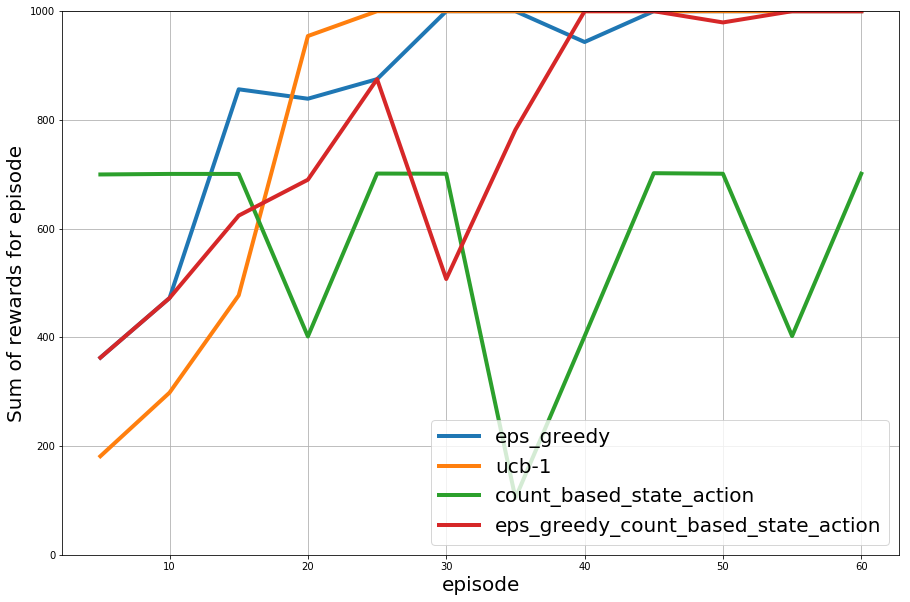

In [39]:
plot_results(experiments, 'results/dqn/chain/')

In [10]:
all_stats = print_results(experiments, 'results/dqn/chain/')

0 eps_greedy
[[  341.           345.           569.           725.           625.        ]
 [  362.66666667   472.33333333   856.33333333   839.           875.        ]
 [  404.           724.          1000.          1000.          1000.        ]]


1 ucb-1
[[  171.           282.           455.           863.          1000.        ]
 [  181.33333333   298.33333333   477.33333333   954.33333333  1000.        ]
 [  193.           307.           519.          1000.          1000.        ]]


2 count_based_state_action
[[   99.           102.           102.           102.           104.        ]
 [  699.66666667   700.66666667   700.66666667   401.66666667
    701.33333333]
 [ 1000.          1000.          1000.          1000.          1000.        ]]


3 count_based_next_state_action
[[   99.           102.           102.           102.           104.        ]
 [  699.66666667   700.66666667   700.66666667   402.           701.33333333]
 [ 1000.          1000.          1000.          100